In [2]:
import sys
!{sys.executable} -m pip install Tensorflow
!{sys.executable} -m pip install Plotly

In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import product
from itertools import cycle
import statsmodels.api as sm

In [5]:
import tensorflow as tf

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras.layers import LSTM

In [6]:
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

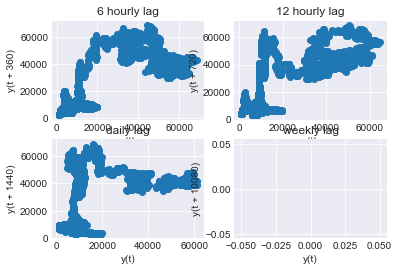

0       2017-04-02
1       2017-04-02
2       2017-04-02
3       2017-04-03
4       2017-04-03
           ...    
7298    2022-04-01
7299    2022-04-01
7300    2022-04-01
7301    2022-04-01
7302    2022-04-02
Name: date, Length: 7303, dtype: object


In [7]:

plt.style.use('seaborn-darkgrid')

btc_input_df = pd.read_csv('historicaldata.csv')
btc_input_df_datetype = btc_input_df.astype({'time': 'datetime64'})
plt.subplot(2,2,1)
pd.plotting.lag_plot(btc_input_df_datetype['close'], lag = 360)
plt.title('6 hourly lag')
plt.subplot(2,2,2)
pd.plotting.lag_plot(btc_input_df_datetype['close'], lag = 720)
plt.title('12 hourly lag')
plt.subplot(2,2,3)
pd.plotting.lag_plot(btc_input_df_datetype['close'], lag = 1440)
plt.title('daily lag')
plt.subplot(2,2,4)
pd.plotting.lag_plot(btc_input_df_datetype['close'], lag = 10080)
plt.title('weekly lag')
plt.show()
btc_input_df_datetype['date'] = pd.to_datetime(btc_input_df_datetype['time'], unit ='s').dt.date
print(btc_input_df_datetype['date'])



In [8]:
group = btc_input_df_datetype.groupby('date')
btc_closing_price_groupby_date = group['close'].mean()
print(btc_closing_price_groupby_date)

date
2017-04-02     1102.723333
2017-04-03     1144.460000
2017-04-04     1147.412500
2017-04-05     1132.380000
2017-04-06     1173.380000
                  ...     
2022-03-29    47630.332500
2022-03-30    47401.697500
2022-03-31    46411.520000
2022-04-01    45630.060000
2022-04-02    46565.090000
Name: close, Length: 1827, dtype: float64


In [9]:
prediction_days = 60
df_train = btc_closing_price_groupby_date[:len(btc_closing_price_groupby_date)-prediction_days].values.reshape(-1,1)
df_test = btc_closing_price_groupby_date[len(btc_closing_price_groupby_date)-prediction_days:].values.reshape(-1,1)

In [10]:
df_train.shape

(1767, 1)

In [11]:
btc_closing_price_groupby_date.shape

(1827,)

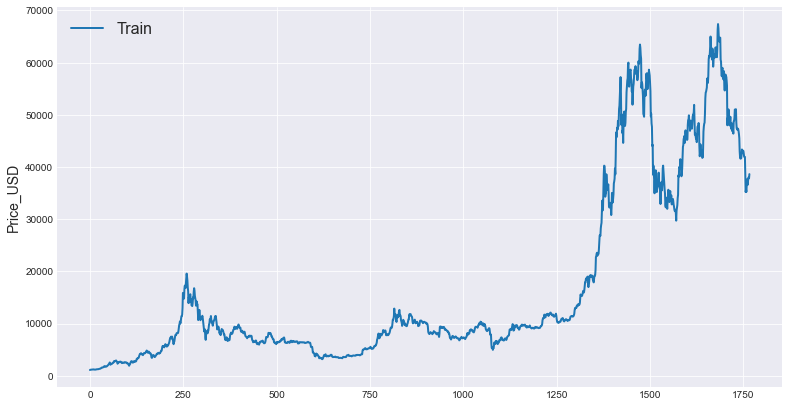

In [12]:
fig, ax = plt.subplots(1, figsize=(13,7))
ax.plot(df_train, label='Train', linewidth=2)
ax.set_ylabel('Price_USD', fontsize = 14)
ax.set_title('', fontsize = 16)
ax.legend(loc='best', fontsize = 16)

In [13]:
scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train)

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test)

In [14]:
print(scaled_train)

[[0.        ]
 [0.00062964]
 [0.00067418]
 ...
 [0.55736843]
 [0.55403365]
 [0.56622232]]


In [15]:
def dataset_generator_lstm(dataset, look_back=5):
    # A “lookback period” defines the window-size of how many
    # previous timesteps are used in order to predict
    # the subsequent timestep. 
    dataX, dataY = [], []
    
    for i in range(len(dataset) - look_back):
        window_size_x = dataset[i:(i + look_back), 0]
        dataX.append(window_size_x)
        dataY.append(dataset[i + look_back, 0]) # this is the label or actual y-value
    return np.array(dataX), np.array(dataY)

trainX, trainY = dataset_generator_lstm(scaled_train)

testX, testY = dataset_generator_lstm(scaled_test)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testY: ", testX.shape)
print("testY", testY.shape)

trainX:  (1762, 5)
trainY:  (1762,)
testY:  (55, 5)
testY (55,)


In [16]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1 ))

print("Shape of trainX: ", trainX.shape)
print("Shape of testX: ", testX.shape)

Shape of trainX:  (1762, 5, 1)
Shape of testX:  (55, 5, 1)


In [17]:
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
# You must set return_sequences=True when stacking LSTM layers so that the second LSTM layer
# has a compatible n-dimensional sequence input.
# This hyper parameter should be set to False (which is the default value) for the last layer
# and true for the other previous layers.

regressor.add(LSTM(units = 128, activation = 'relu',return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 64, input_shape = (trainX.shape[1], trainX.shape[2])))
# regressor.add(LSTM(units = 64, return_sequences = True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))
# Note - If I plan to add 3-rd or 4-th layers of LSTM then 
# I must set return_sequences=True in the 2-nd layer above
# so that the 3-rd LSTM layer has a compatible n-dimensional sequence input.


# Adding a third LSTM layer and some Dropout regularisation
# regressor.add(LSTM(units = 64, return_sequences = True, input_shape = (trainX.shape[1], trainX.shape[2])))
# regressor.add(Dropout(0.2))


# Adding a fourth LSTM layer and some Dropout regularisation
# regressor.add(LSTM(units = 64, input_shape = (trainX.shape[1], trainX.shape[2])))
# regressor.add(Dropout(0.2))


# Adding the output layer
regressor.add(Dense(units = 1))

regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 128)            66560     
_________________________________________________________________
dropout (Dropout)            (None, 5, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Compiling the LSTM
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

checkpoint_path = 'my_best_model.hdf5'

checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')


earlystopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

callbacks = [checkpoint, earlystopping]


history = regressor.fit(trainX, trainY, batch_size = 32, epochs = 300, verbose=1, shuffle=False, validation_data=(testX, testY), callbacks=callbacks)

Epoch 1/300
56/56 [==============================] - 5s 19ms/step - loss: 0.0166 - val_loss: 0.0627

Epoch 1: val_loss improved from inf to 0.06271, saving model to my_best_model.hdf5
Epoch 2/300
56/56 [==============================] - 1s 11ms/step - loss: 0.0316 - val_loss: 0.0865

Epoch 2: val_loss did not improve from 0.06271
Epoch 3/300
56/56 [==============================] - 1s 10ms/step - loss: 0.0283 - val_loss: 0.0459

Epoch 3: val_loss improved from 0.06271 to 0.04592, saving model to my_best_model.hdf5
Epoch 4/300
56/56 [==============================] - 1s 11ms/step - loss: 0.0091 - val_loss: 0.0359

Epoch 4: val_loss improved from 0.04592 to 0.03587, saving model to my_best_model.hdf5
Epoch 5/300
56/56 [==============================] - 1s 12ms/step - loss: 0.0059 - val_loss: 0.0371

Epoch 5: val_loss did not improve from 0.03587
Epoch 6/300
56/56 [==============================] - 1s 13ms/step - loss: 0.0049 - val_loss: 0.0366

Epoch 6: val_loss did not improve from 0.03

56/56 [==============================] - 1s 13ms/step - loss: 0.0021 - val_loss: 0.0311

Epoch 50: val_loss improved from 0.03135 to 0.03114, saving model to my_best_model.hdf5
Epoch 51/300
56/56 [==============================] - 1s 14ms/step - loss: 0.0017 - val_loss: 0.0307

Epoch 51: val_loss improved from 0.03114 to 0.03069, saving model to my_best_model.hdf5
Epoch 52/300
56/56 [==============================] - 1s 14ms/step - loss: 0.0017 - val_loss: 0.0309

Epoch 52: val_loss did not improve from 0.03069
Epoch 53/300
56/56 [==============================] - 1s 15ms/step - loss: 0.0019 - val_loss: 0.0308

Epoch 53: val_loss did not improve from 0.03069
Epoch 54/300
56/56 [==============================] - 1s 17ms/step - loss: 0.0019 - val_loss: 0.0303

Epoch 54: val_loss improved from 0.03069 to 0.03034, saving model to my_best_model.hdf5
Epoch 55/300
56/56 [==============================] - 1s 14ms/step - loss: 0.0021 - val_loss: 0.0305

Epoch 55: val_loss did not improve from 0

Epoch 99/300
56/56 [==============================] - 1s 14ms/step - loss: 0.0026 - val_loss: 0.0265

Epoch 99: val_loss did not improve from 0.02509
Epoch 100/300
56/56 [==============================] - 1s 14ms/step - loss: 0.0019 - val_loss: 0.0259

Epoch 100: val_loss did not improve from 0.02509
Epoch 101/300
56/56 [==============================] - 1s 14ms/step - loss: 0.0011 - val_loss: 0.0253

Epoch 101: val_loss did not improve from 0.02509
Epoch 102/300
56/56 [==============================] - 1s 14ms/step - loss: 9.7412e-04 - val_loss: 0.0250

Epoch 102: val_loss improved from 0.02509 to 0.02500, saving model to my_best_model.hdf5
Epoch 103/300
56/56 [==============================] - 1s 15ms/step - loss: 8.9917e-04 - val_loss: 0.0248

Epoch 103: val_loss improved from 0.02500 to 0.02483, saving model to my_best_model.hdf5
Epoch 104/300
56/56 [==============================] - 1s 13ms/step - loss: 9.3446e-04 - val_loss: 0.0250

Epoch 104: val_loss did not improve from 0.0248

Epoch 148/300
56/56 [==============================] - 1s 15ms/step - loss: 9.9112e-04 - val_loss: 0.0201

Epoch 148: val_loss improved from 0.02054 to 0.02006, saving model to my_best_model.hdf5
Epoch 149/300
56/56 [==============================] - 1s 14ms/step - loss: 0.0013 - val_loss: 0.0203

Epoch 149: val_loss did not improve from 0.02006
Epoch 150/300
56/56 [==============================] - 1s 20ms/step - loss: 0.0012 - val_loss: 0.0200

Epoch 150: val_loss improved from 0.02006 to 0.02003, saving model to my_best_model.hdf5
Epoch 151/300
56/56 [==============================] - 1s 20ms/step - loss: 0.0015 - val_loss: 0.0200

Epoch 151: val_loss improved from 0.02003 to 0.02002, saving model to my_best_model.hdf5
Epoch 152/300
56/56 [==============================] - 1s 17ms/step - loss: 0.0014 - val_loss: 0.0204

Epoch 152: val_loss did not improve from 0.02002
Epoch 153/300
56/56 [==============================] - 1s 18ms/step - loss: 0.0012 - val_loss: 0.0200

Epoch 153: va

In [19]:
from tensorflow.keras.models import load_model

model_from_saved_checkpoint = load_model(checkpoint_path)

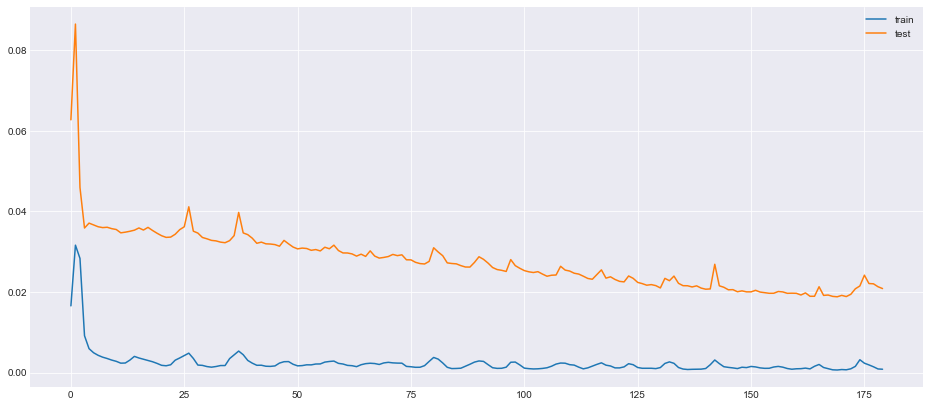

In [20]:
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')

plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [21]:
# Transformation to original form and making the predictions

# predicted_btc_price_test_data = regressor.predict(testX)
predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)

predicted_btc_price_test_data = scaler_test.inverse_transform(predicted_btc_price_test_data.reshape(-1, 1))

test_actual = scaler_test.inverse_transform(testY.reshape(-1, 1))

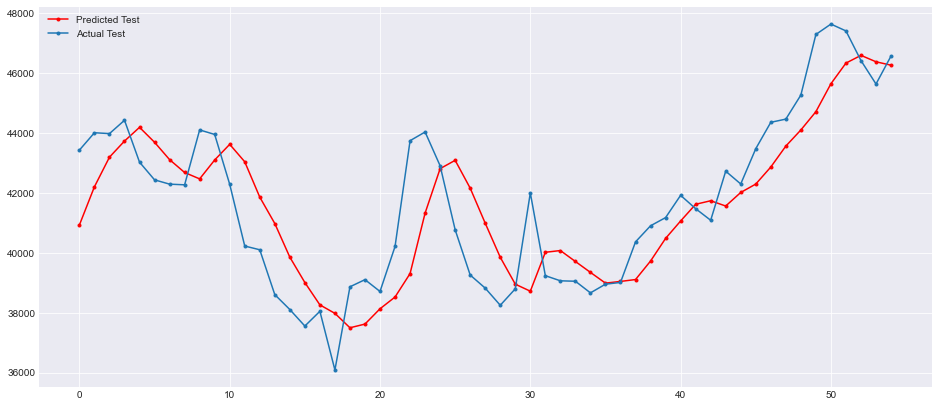

In [22]:
plt.figure(figsize=(16,7))

plt.plot(predicted_btc_price_test_data, 'r', marker='.', label='Predicted Test')

plt.plot(test_actual, marker='.', label='Actual Test')

plt.legend()
plt.show()

In [23]:
# Transformation to original form and making the predictions

predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)

predicted_btc_price_train_data = scaler_train.inverse_transform(predicted_btc_price_train_data.reshape(-1, 1))

train_actual = scaler_train.inverse_transform(trainY.reshape(-1, 1))

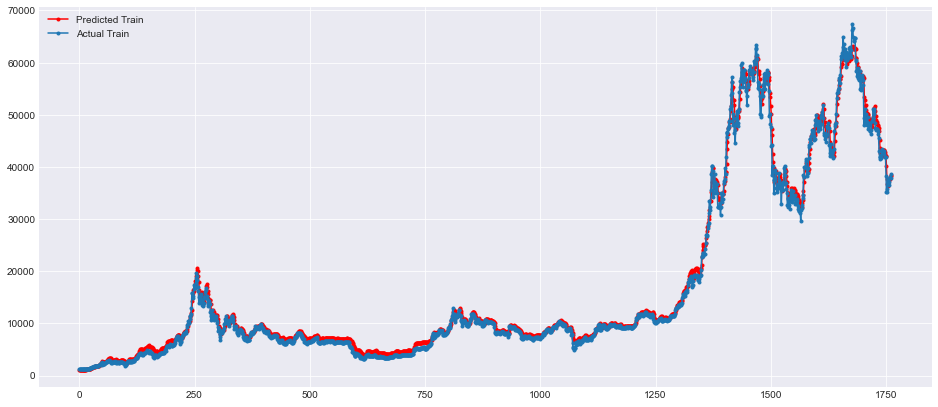

In [24]:
plt.figure(figsize=(16,7))

plt.plot(predicted_btc_price_train_data, 'r', marker='.', label='Predicted Train')

plt.plot(train_actual, marker='.', label='Actual Train')

plt.legend()
plt.show()

In [25]:
rmse_lstm_test = math.sqrt(mean_squared_error(test_actual, predicted_btc_price_test_data))

print('Test RMSE: %.3f' % rmse_lstm_test)

# With 2 Layers + Dropout + lookback=5 => I got - Test RMSE: 1666.162  => This seems best

Test RMSE: 1583.127


In [26]:
rmse_lstm_train = math.sqrt(mean_squared_error(train_actual, predicted_btc_price_train_data))

print('Test RMSE: %.3f' % rmse_lstm_train)

# With 2 Layers + Dropout + lookback=5 => I got - Test RMSE: 1047.916  => This seems best

Test RMSE: 1185.239


In [32]:
lookback_period = 5
print(testX.shape)
testX_last_5_days = testX[testX.shape[0] - lookback_period :]

print(testX_last_5_days.shape)

(55, 5, 1)
(5, 5, 1)


In [37]:

print(testX_last_5_days)

[[[0.63977693]
  [0.71605424]
  [0.72526312]
  [0.79479559]
  [0.97002952]]

 [[0.71605424]
  [0.72526312]
  [0.79479559]
  [0.97002952]
  [1.        ]]

 [[0.72526312]
  [0.79479559]
  [0.97002952]
  [1.        ]
  [0.98019638]]

 [[0.79479559]
  [0.97002952]
  [1.        ]
  [0.98019638]
  [0.89443041]]

 [[0.97002952]
  [1.        ]
  [0.98019638]
  [0.89443041]
  [0.82674288]]]


In [38]:
predicted_5_days_forecast_price_test_x = []
for i in range(5):
    predicted_forecast_price_test_x = model_from_saved_checkpoint.predict(testX_last_5_days[i:i+1])
    
    predicted_forecast_price_test_x = scaler_test.inverse_transform(predicted_forecast_price_test_x.reshape(-1,1))
   
    predicted_5_days_forecast_price_test_x.append(predicted_forecast_price_test_x)
print(np.array(predicted_5_days_forecast_price_test_x))

[[[45638.89 ]]

 [[46328.08 ]]

 [[46586.047]]

 [[46371.715]]

 [[46258.02 ]]]


In [45]:
predicted_5_days_forecast_price_test_x = np.array(predicted_5_days_forecast_price_test_x)
predicted_5_days_forecast_price_test_x = predicted_5_days_forecast_price_test_x.flatten()
print(predicted_5_days_forecast_price_test_x)

[45638.89  46328.08  46586.047 46371.715 46258.02 ]


In [46]:
predicted_btc_price_test_data = predicted_btc_price_test_data.flatten()
print(predicted_btc_price_test_data )

[40924.926 42201.28  43189.074 43726.21  44184.12  43685.6   43106.01
 42677.016 42463.918 43094.39  43617.043 43034.76  41854.758 40974.22
 39851.254 39004.668 38258.45  37975.78  37494.734 37618.195 38128.36
 38521.06  39303.707 41322.586 42805.77  43083.105 42154.    40984.527
 39847.22  38949.723 38715.242 40014.43  40072.203 39706.754 39342.957
 38984.375 39041.66  39104.26  39722.22  40477.53  41058.332 41615.793
 41733.867 41557.938 42010.215 42290.812 42859.78  43557.926 44095.902
 44706.664 45638.887 46328.082 46586.043 46371.71  46258.02 ]


In [50]:
predicted_btc_test_concatenated = np.concatenate((predicted_btc_price_test_data, predicted_5_days_forecast_price_test_x))

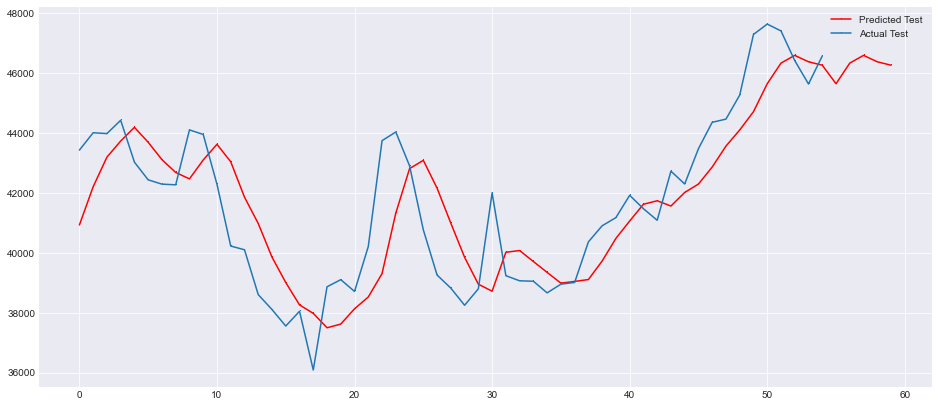

In [51]:
plt.figure(figsize = (16,7))
plt.plot(predicted_btc_test_concatenated, 'r', marker=',', label = 'Predicted Test')
plt.plot(test_actual, marker = ',', label = 'Actual Test')
plt.legend()
plt.show()